In [12]:
#!pip install folium
#!pip install lightgbm
#!pip install impyute

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import folium
from folium.plugins import FloatImage
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
import warnings
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

In [14]:
listings = pd.read_csv('airbnb/listings.csv.gz')
calendar = pd.read_csv('airbnb/calendar.csv.gz')
reviews = pd.read_csv('airbnb/reviews.csv.gz')

In [15]:
calendar.shape

(8539992, 7)

In [16]:
reviews.shape

(653723, 6)

In [255]:
listings.shape

(23397, 106)

In [18]:
listings.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,...,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1419,https://www.airbnb.com/rooms/1419,20191207213017,2019-12-08,Beautiful home in amazing area!,"This large, family home is located in one of T...",Visit Toronto with this fabulous furnished hom...,"This large, family home is located in one of T...",none,The apartment is located in the Ossington stri...,"To learn a little more about our home, see: (U...",All forms of public transportation are easily ...,The whole house and garden are available.,"We will be out of town, but fully accessible b...",This is our much-loved family home. We expect ...,NaN,NaN,https://a0.muscache.com/im/pictures/76206750/d...,NaN,1565,https://www.airbnb.com/users/show/1565,Alexandra,2008-08-08,"Toronto, Ontario, Canada","I live in Toronto, Canada with my husband and ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1565/profile_...,https://a0.muscache.com/im/users/1565/profile_...,Commercial Drive,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Toronto, ON, Canada",Little Portugal,Little Portugal,NaN,Toronto,ON,M6J,Toronto,"Toronto, Canada",CA,Canada,43.64617,-79.42451,...,7.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",1400.0,$469.00,"$2,000.00",NaN,"$1,000.00",$150.00,1,$0.00,4,730,4,4,730,730,4.0,730.0,22 months ago,t,0,0,0,0,2019-12-08,7,0,2015-07-19,2017-12-04,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.13


In [19]:
calendar.head(1)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,291699,2019-12-08,t,$34.00,$34.00,80.0,90.0


In [20]:
calendar['available'] = calendar.available.map(lambda x: 1 if x=='t' else 0)
calendar.date = pd.to_datetime(calendar.date)
calendar.price = calendar.price.str.replace("$", "").str.replace(",","")
calendar.price = calendar.price.astype("float")
calendar.adjusted_price = calendar.adjusted_price.str.replace("$", "").str.replace(",","")
calendar.adjusted_price = calendar.adjusted_price.astype("float")

In [266]:
print(f'Minimum date of listing {calendar.date.min()}')
print(f'Maximum date of listing {calendar.date.max()}')

Minimum date of listing 2019-12-07 00:00:00
Maximum date of listing 2020-12-06 00:00:00


In [22]:
calendar_365 = calendar.groupby(
    'date')['available', 'price'].mean().reset_index()
calendar_365.rename(
    columns={'price': 'average_price', 'available': 'vacancy'}, inplace=True)
calendar_365['occupancy'] = (1 - calendar_365['vacancy']) * 100

In [23]:
calendar_365.head()

,date,vacancy,average_price,occupancy
0,2019-12-07,0.014997,154.398500,98.500268
1,2019-12-08,0.260632,130.706928,73.936830
2,2019-12-09,0.338248,130.979527,66.175151
3,2019-12-10,0.358849,131.283455,64.115057
4,2019-12-11,0.377570,131.149164,62.243023


In [24]:
calendar_365['dayofweek'] = calendar_365.date.dt.weekday_name.str[:3]
calendar_365['month'] = calendar_365.date.dt.month_name().str[:3]

In [26]:
def plot_calendar(groupby_col, agg_col):
    df_index = list(calendar_365[groupby_col].unique())
    grouped_df = calendar_365.groupby(
        groupby_col)[agg_col].mean().reindex(df_index)

    #print(grouped_df.head(2))
    plt.plot(grouped_df)
    plt.ylabel(agg_col.replace('_', ' ').title())
    plt.title(" {} by {}".format(agg_col.replace('_', ' ').title(),
                                 groupby_col.title()), fontsize=18, fontweight='bold')
    ticks = list(range(len(df_index)))
    labels = df_index
    plt.xticks(ticks, labels)
    plt.show()

## Which months are busiest and idlest to visit Toronto?

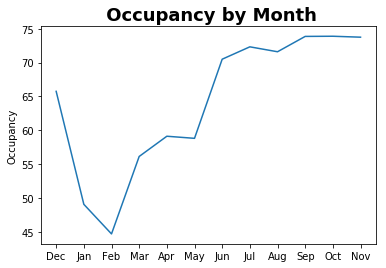

In [27]:
plot_calendar('month', 'occupancy')

## Which days of week are most busy and least busy to visit Toronto?

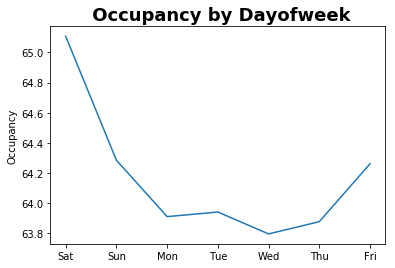

In [28]:
plot_calendar('dayofweek', 'occupancy')

## Which days of week are most expensive and least expensive to visit Toronto?

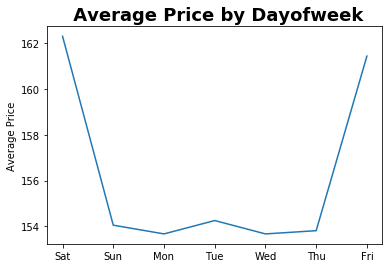

In [29]:
plot_calendar('dayofweek', 'average_price')

## Which neighborhoods has the most and the least expensive listings?

In [31]:
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,...,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1419,https://www.airbnb.com/rooms/1419,20191207213017,2019-12-08,Beautiful home in amazing area!,"This large, family home is located in one of T...",Visit Toronto with this fabulous furnished hom...,"This large, family home is located in one of T...",none,The apartment is located in the Ossington stri...,"To learn a little more about our home, see: (U...",All forms of public transportation are easily ...,The whole house and garden are available.,"We will be out of town, but fully accessible b...",This is our much-loved family home. We expect ...,NaN,NaN,https://a0.muscache.com/im/pictures/76206750/d...,NaN,1565,https://www.airbnb.com/users/show/1565,Alexandra,2008-08-08,"Toronto, Ontario, Canada","I live in Toronto, Canada with my husband and ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1565/profile_...,https://a0.muscache.com/im/users/1565/profile_...,Commercial Drive,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Toronto, ON, Canada",Little Portugal,Little Portugal,NaN,Toronto,ON,M6J,Toronto,"Toronto, Canada",CA,Canada,43.64617,-79.42451,...,7.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",1400.0,$469.00,"$2,000.00",NaN,"$1,000.00",$150.00,1,$0.00,4,730,4,4,730,730,4.0,730.0,22 months ago,t,0,0,0,0,2019-12-08,7,0,2015-07-19,2017-12-04,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.13
1,8077,https://www.airbnb.com/rooms/8077,20191207213017,2019-12-08,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,My husband and I are both artists. I give pain...,Guest room in a luxury condo with access to al...,none,NaN,NaN,NaN,NaN,NaN,No smoking please.,NaN,NaN,https://a0.muscache.com/im/pictures/11780344/1...,NaN,22795,https://www.airbnb.com/users/show/22795,Kathie & Larry,2009-06-22,"Toronto, Ontario, Canada",My husband and I have been airbnb host for alm...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/9a077...,https://a0.muscache.com/im/pictures/user/9a077...,Harbourfront,2.0,2.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Toronto, ON, Canada",Downtown Toronto,Waterfront Communities-The Island,NaN,Toronto,ON,M5J,Toronto,"Toronto, Canada",CA,Canada,43.64105,-79.37628,...,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,$99.00,NaN,"$2,651.00"

In [32]:
### Count of listings

listings.groupby('neighbourhood_cleansed')['id'].count()

neighbourhood_cleansed
Agincourt North                        51
Agincourt South-Malvern West          103
Alderwood                              33
Annex                                 851
Banbury-Don Mills                      66
Bathurst Manor                         81
Bay Street Corridor                   686
Bayview Village                       116
Bayview Woods-Steeles                  84
Bedford Park-Nortown                   49
Beechborough-Greenbrook                12
Bendale                                63
Birchcliffe-Cliffside                 107
Black Creek                            18
Blake-Jones                            86
Briar Hill-Belgravia                   69
Bridle Path-Sunnybrook-York Mills      18
Broadview North                        63
Brookhaven-Amesbury                    39
Cabbagetown-South St.James Town       328
Caledonia-Fairbank                     40
Casa Loma                              92
Centennial Scarborough                 19
Church-Yong

In [33]:
def count_plot(df, groupby_col, agg_col, plot_type, top_k=10):
    if plot_type == 'count':

        if agg_col == 'id':
            grouped_df = df.groupby(groupby_col)[agg_col].count()
            order_index = grouped_df.sort_values(ascending=False).index[:top_k]
            
            splot = sns.countplot(x=groupby_col, data=df,palette="Set1",
                                  order=order_index)

            

            plt.xlabel('Neighborhood')
            plt.ylabel('Listings count')
            plt.title('Top neighborhoods based on listing counts',
                      fontsize=18, fontweight='bold')
            
            
        
    plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'
    )
    plt.show()

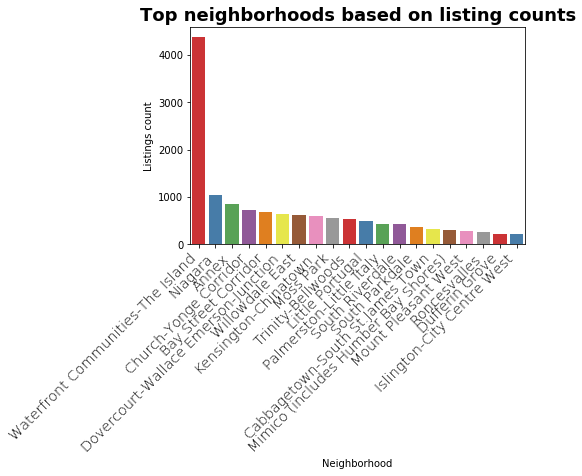

In [34]:
count_plot(listings, 'neighbourhood_cleansed', 'id', 'count', 20)

In [35]:
listings.price = listings.price.str.replace("$", "").str.replace(",","")
listings.price = listings.price.astype("float")

In [37]:
### Average price per neighbourhood

listings.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)[:20]

neighbourhood_cleansed
Forest Hill South                    358.833333
Casa Loma                            333.717391
Waterfront Communities-The Island    226.676571
Kensington-Chinatown                 218.090604
Clanton Park                         197.137500
Rosedale-Moore Park                  196.649573
Kingsway South                       196.000000
Lawrence Park South                  185.033333
Lawrence Park North                  179.385965
Bedford Park-Nortown                 178.836735
Bay Street Corridor                  173.870262
Annex                                173.320799
Edenbridge-Humber Valley             170.304348
Niagara                              166.900763
Leaside-Bennington                   166.508475
Church-Yonge Corridor                164.674515
Yonge-Eglinton                       163.633333
Banbury-Don Mills                    162.212121
Markland Wood                        159.500000
Yonge-St.Clair                       157.678161
Name: price, dtyp

In [82]:
listings.price.describe()

count    23397.000000
mean       148.707099
std        329.417941
min          0.000000
25%         65.000000
50%         99.000000
75%        160.000000
max      13255.000000
Name: price, dtype: float64

In [38]:
### Minimum listing and the neighbourhood

listings[listings.price == listings.price.min()][['neighbourhood_cleansed', 'price']]

,neighbourhood_cleansed,price
7971,Little Portugal,0.0
8031,Agincourt North,0.0
8148,Dovercourt-Wallace Emerson-Junction,0.0
8273,Hillcrest Village,0.0


In [39]:
### Maximum listing and the neighbourhood

listings[listings.price == listings.price.max()][['neighbourhood_cleansed', 'price']]

,neighbourhood_cleansed,price
5778,Annex,13255.0


## Price vs Number of Reviews

Text(0.5, 1.0, 'Price vs Number of Reviews')

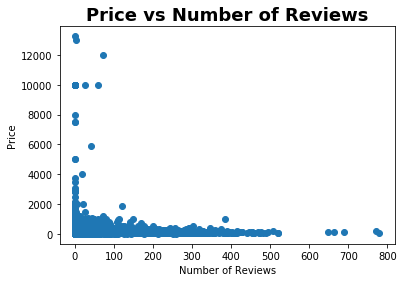

In [97]:
plt.scatter(x=listings['number_of_reviews'], y=listings['price'])
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.title('Price vs Number of Reviews', fontsize=18, fontweight='bold')

In [124]:
grouped_df = listings.groupby('neighbourhood_cleansed')['id'].count()
top_nbrhd_list = list(grouped_df.sort_values(ascending=False).index[:25])
top_nbrhd = listings[listings['neighbourhood_cleansed'].isin(top_nbrhd_list)]

In [125]:
top_nbrhd.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,...,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1419,https://www.airbnb.com/rooms/1419,20191207213017,2019-12-08,Beautiful home in amazing area!,"This large, family home is located in one of T...",Visit Toronto with this fabulous furnished hom...,"This large, family home is located in one of T...",none,The apartment is located in the Ossington stri...,"To learn a little more about our home, see: (U...",All forms of public transportation are easily ...,The whole house and garden are available.,"We will be out of town, but fully accessible b...",This is our much-loved family home. We expect ...,NaN,NaN,https://a0.muscache.com/im/pictures/76206750/d...,NaN,1565,https://www.airbnb.com/users/show/1565,Alexandra,2008-08-08,"Toronto, Ontario, Canada","I live in Toronto, Canada with my husband and ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1565/profile_...,https://a0.muscache.com/im/users/1565/profile_...,Commercial Drive,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Toronto, ON, Canada",Little Portugal,Little Portugal,NaN,Toronto,ON,M6J,Toronto,"Toronto, Canada",CA,Canada,43.64617,-79.42451,...,7.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",1400.0,469.0,"$2,000.00",NaN,"$1,000.00",$150.00,1,$0.00,4,730,4,4,730,730,4.0,730.0,22 months ago,t,0,0,0,0,2019-12-08,7,0,2015-07-19,2017-12-04,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.13
1,8077,https://www.airbnb.com/rooms/8077,20191207213017,2019-12-08,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,My husband and I are both artists. I give pain...,Guest room in a luxury condo with access to al...,none,NaN,NaN,NaN,NaN,NaN,No smoking please.,NaN,NaN,https://a0.muscache.com/im/pictures/11780344/1...,NaN,22795,https://www.airbnb.com/users/show/22795,Kathie & Larry,2009-06-22,"Toronto, Ontario, Canada",My husband and I have been airbnb host for alm...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/9a077...,https://a0.muscache.com/im/pictures/user/9a077...,Harbourfront,2.0,2.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Toronto, ON, Canada",Downtown Toronto,Waterfront Communities-The Island,NaN,Toronto,ON,M5J,Toronto,"Toronto, Canada",CA,Canada,43.64105,-79.37628,...,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,99.0,NaN,"$2,651.00","$2

## Scatter plot — Average price vs Number of Reviews

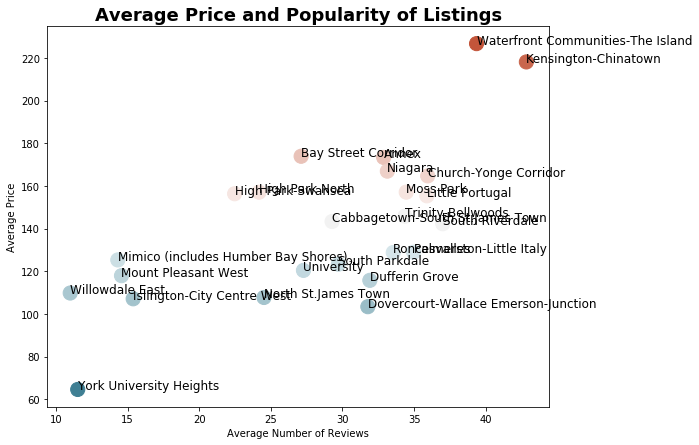

In [136]:
def plot_price_vs_popularity(df, top_k):
    x = df.groupby('neighbourhood_cleansed')[
        'number_of_reviews'].mean().sort_index()[:top_k]
    y = df.groupby('neighbourhood_cleansed')[
        'price'].mean().sort_index()[:top_k]
    n = (x.reset_index()).neighbourhood_cleansed.tolist()[:top_k]
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.scatter(x, y, c=y, cmap=sns.diverging_palette(
        220, 20, sep=20, as_cmap=True), s=200)

    for i, txt in enumerate(n):
        ax.annotate(txt, (x[i], y[i]), fontsize=12)

    plt.xlabel('Average Number of Reviews')
    plt.ylabel('Average Price')
    plt.title('Average Price and Popularity of Listings',
              fontsize=18, fontweight='bold')

plot_price_vs_popularity(top_nbrhd, 25)

# Modeling and Feature Engineering:

## Building a regression model to predict the price of the listings

In [216]:
features = ['cancellation_policy', 'is_location_exact', 'accommodates', 'reviews_per_month', 'property_type',
            'host_total_listings_count', 'extra_people', 'calculated_host_listings_count', 'guests_included',
            'review_scores_rating', 'host_response_time', 'number_of_reviews', 'host_is_superhost', 'room_type',
            'instant_bookable', 'amenities', 'host_identity_verified', 'host_has_profile_pic', 'security_deposit',
            'host_listings_count', 'requires_license','neighbourhood_cleansed',
            'minimum_nights', 'bathrooms', 'require_guest_phone_verification', 'cleaning_fee',
           'bed_type', 'price']


In [217]:
data = listings[features].copy()

In [218]:
data.cleaning_fee = data.cleaning_fee.str.replace('$', '').str.replace(',', '')
data.cleaning_fee = data.cleaning_fee.astype(float)

data.security_deposit = data.security_deposit.str.replace(
    '$', '').str.replace(',', '')
data.security_deposit = data.security_deposit.astype(float)

data.extra_people = data.extra_people.str.replace('$', '').str.replace(',', '')
data.extra_people = data.extra_people.astype(float)


In [219]:
data.shape

(23397, 28)

### Numercical columns filling null values

In [220]:
num_cols = data.select_dtypes(exclude='object')
num_cols.isnull().sum()

accommodates                         0
reviews_per_month                 4390
host_total_listings_count          285
extra_people                         0
calculated_host_listings_count       0
guests_included                      0
review_scores_rating              4676
number_of_reviews                    0
security_deposit                  5413
host_listings_count                285
minimum_nights                       0
bathrooms                           10
cleaning_fee                      3611
price                                0
dtype: int64

## MICE (Multiple Imputation by Chained Equations)

To handle missing values in numerical columns

Better than Mean / Median Imputation as it keeps the variance as close to the original data
and does not create bias

In [221]:

from impyute.imputation.cs import mice

imputed_num_cols = mice(num_cols.values)

In [222]:
num_column_names = ['accommodates', 'reviews_per_month',
       'host_total_listings_count', 'extra_people',
       'calculated_host_listings_count', 'guests_included',
       'review_scores_rating', 'number_of_reviews', 'security_deposit',
       'host_listings_count', 'minimum_nights', 'bathrooms', 'cleaning_fee', 'price']

In [223]:
imputed_num_data = pd.DataFrame(imputed_num_cols, columns = num_column_names)

In [224]:
imputed_num_data.reviews_per_month = imputed_num_data.reviews_per_month.apply(lambda x: 0 if x <0 else x)
imputed_num_data.security_deposit = imputed_num_data.security_deposit.apply(lambda x: 0 if x <0 else x)

In [225]:
transformed_df = imputed_num_data.copy()

transformed_df[num_column_names] = transformed_df[num_column_names].apply(lambda x: np.log(x+1))

num_column_names.remove('price')
scaler = MinMaxScaler()
transformed_df[num_column_names] = scaler.fit_transform(transformed_df[num_column_names])


### Categorical columns filling null values

In [226]:
transformed_df.head()

,accommodates,reviews_per_month,host_total_listings_count,extra_people,calculated_host_listings_count,guests_included,review_scores_rating,number_of_reviews,security_deposit,host_listings_count,minimum_nights,bathrooms,cleaning_fee,price
0,0.796587,0.040490,0.119589,0.000000,0.000000,0.000000,0.877793,0.312262,0.784874,0.119589,0.144679,0.615777,0.614802,6.152733
1,0.189464,0.283062,0.189545,0.000000,0.098632,0.000000,0.860941,0.771223,0.895562,0.189545,0.711377,0.407007,0.595657,4.605170
2,0.000000,0.185016,0.119589,0.507932,0.000000,0.000000,0.844910,0.000000,0.556423,0.119589,0.000000,0.407007,0.408318,4.204693
3,0.323891,0.346970,0.189545,0.507932,0.098632,0.189464,0.849417,0.807184,0.000000,0.189545,0.000000,0.307889,0.000000,4.290459
4,0.513354,0.099423,0.358768,0.491234,0.337226,0.189464,0.849417,0.550143,0.648360,0.358768,0.144679,0.307889,0.484173,5.298317


In [227]:
cat_cols = data.select_dtypes(include='object')
cat_cols.isnull().sum()

cancellation_policy                    0
is_location_exact                      0
property_type                          0
host_response_time                  6609
host_is_superhost                    285
room_type                              0
instant_bookable                       0
amenities                              0
host_identity_verified               285
host_has_profile_pic                 285
requires_license                       0
neighbourhood_cleansed                 0
require_guest_phone_verification       0
bed_type                               0
dtype: int64

In [228]:
cat_cols = cat_cols.apply(lambda col: col.fillna(col.mode()[0]))

In [229]:
cat_cols.head()

,cancellation_policy,is_location_exact,property_type,host_response_time,host_is_superhost,room_type,instant_bookable,amenities,host_identity_verified,host_has_profile_pic,requires_license,neighbourhood_cleansed,require_guest_phone_verification,bed_type
0,strict_14_with_grace_period,f,House,within an hour,f,Entire home/apt,f,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",t,t,f,Little Portugal,f,Real Bed
1,strict_14_with_grace_period,t,Apartment,within an hour,f,Private room,t,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",f,t,f,Waterfront Communities-The Island,t,Real Bed
2,moderate,t,House,within an hour,f,Private room,f,"{Internet,Wifi,""Pets live on this property"",Ca...",t,t,f,Annex,f,Pull-out Sofa
3,strict_14_with_grace_period,t,House,within an hour,t,Private room,t,"{Internet,Wifi,""Air conditioning"",Kitchen,""Fre...",t,t,f,Briar Hill-Belgravia,f,Real Bed
4,strict_14_with_grace_period,t,Condominium,within an hour,f,Entire home/apt,f,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",t,t,f,Waterfront Communities-The Island,f,Real Bed


In [230]:
dummies = ['property_type', 'room_type', 'cancellation_policy',
           'host_response_time', 'neighbourhood_cleansed', 'bed_type']

In [231]:
for cat_feature in dummies:
    cat_cols = pd.concat([cat_cols, pd.get_dummies(cat_cols[cat_feature], prefix=cat_feature)], axis=1)

In [232]:
imputed_cat_data = cat_cols.drop(dummies,axis=1)

In [233]:
columns =  ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'is_location_exact', 'requires_license', 'instant_bookable', 'require_guest_phone_verification']
for c in columns:
    imputed_cat_data[c] = imputed_cat_data[c].replace('f',0,regex=True)
    imputed_cat_data[c] = imputed_cat_data[c].replace('t',1,regex=True)

In [234]:
print(imputed_cat_data.shape)
print(imputed_num_data.shape)

(23397, 196)
(23397, 14)


In [235]:
data_clean = pd.concat([transformed_df, imputed_cat_data], axis=1, join = 'inner')

In [236]:
data_clean.shape

(23397, 210)

In [237]:
data_clean['number_of_amenities'] = data_clean['amenities'].apply(
    lambda x: len(x.replace('{', '').replace('}', '').split(',')))

In [238]:
data_clean.amenities = data_clean.amenities.str.replace("[{}]", "").str.replace('"', "")
count_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(','))
amenities = count_vectorizer.fit_transform(data_clean['amenities'])


In [239]:
feature_names = []
for i, f in enumerate(count_vectorizer.get_feature_names()):
    feature_names.append('f'+str(i))

In [240]:
df_amenities = pd.DataFrame(amenities.toarray(), columns=feature_names)
df_amenities = df_amenities.drop('f0',1)

In [242]:
data_clean.drop('amenities',axis=1, inplace=True)

In [243]:
listing_data = pd.concat([data_clean, df_amenities], axis=1,join = 'inner')

In [244]:
listing_data.shape

(23397, 411)

In [245]:
listing_data.describe()

,accommodates,reviews_per_month,host_total_listings_count,extra_people,calculated_host_listings_count,guests_included,review_scores_rating,number_of_reviews,security_deposit,host_listings_count,minimum_nights,bathrooms,cleaning_fee,price,is_location_exact,host_is_superhost,instant_bookable,host_identity_verified,host_has_profile_pic,requires_license,require_guest_phone_verification,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Casa particular (Cuba),property_type_Castle,property_type_Cave,property_type_Condominium,property_type_Cottage,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Lighthouse,property_type_Loft,property_type_Other,property_type_Parking Space,property_type_Resort,property_type_Serviced apartment,property_type_Tiny house,property_type_Townhouse,property_type_Train,...,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174,f175,f176,f177,f178,f179,f180,f181,f182,f183,f184,f185,f186,f187,f188,f189,f190,f191,f192,f193,f194,f195,f196,f197,f198,f199,f200,f201
count,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.0,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.00000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,...,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.00000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.00000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000,23397.000000
mean,0.298875,0.272874,0.218579,0.266485,0.137853,0.104094,0.842170,0.330029,0.515345,0.218579,0.094002,0.350468,0.460406,4.670523,0.814677,0.266786,0.413215,0.328589,0.996709,0.0,0.009317,0.000171,0.287729,0.000470,0.001710,0.000171,0.004360,0.034705,0.000043,0.000171,0.000085,0.000085,0.000085,0.279737,0.000385,0.000085,0.041843,0.005514,0.000983,0.00094,0.263538,0.000043,0.019746,0.002009,0.000043,0.000043,0.005129,0.000470,0.045177,0.000043,...,0.105355,0.000128,0.343506,0.800658,0.001923,0.000598,0.000812,0.00141,0.001496,0.067786,0.000256,0.045903,0.005770,0.945164,0.030987,0.002607,0.002436,0.009617,0.000171,0.000085,0.000214,0.007651,0.464547,0.023764,0.000769,0.002265,0.000043,0.002052,0.014788,0.000128,0.087276,0.108048,0.00141,0.715904,0.003975,0.000684,0.806813,0.000085,0.033124,0.097021,0.045690,0.019746,0.027183,0.051246,0.064453,0.044450,0.068898,0.982476,0.007822,0.000470
std,0.195899,0.191182,0.163134,0.271497,0.200129,0.166395,0.058758,0.240237,0.267401,0.163134,0.133103,0.087943,0.128547,0.720880,0.388568,0.442289,0.492421,0.469710,0.057274,0.0,0.096078,0.013074,0.452714,0.021678,0.041313,0.013074,0.065884,0.183036,0.006538,0.013074,0.009245,0.009245,0.009245,0.448879,0.019610,0.009245,0.200234,0.074050,0.031339,0.03065,0.440561,0.006538,0.139130,0.044776,0.006538,0.006538,0.071434,0.021678,0.207696,0.006538,...,0.307017,0.0113

## Modeling Step: 

### Used Light GBM as the model because:

Faster training speed and convergence

Lower memory usage

Can handle very large size data-sets

Better accuracy than any other boosting algorithm

In [ ]:
def train_and_test(df, model, test_size=0.2):
    target = df['price']
    features = df.copy().drop('price', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=test_size, random_state=42)

    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test) 
    print('R^2 test: %.3f' % (r2_score(y_test, y_pred)))
    pred = np.round(np.exp(y_pred) + 1, 1)
    actual = np.round(np.exp(y_test) + 1, 1)
    plt.scatter(actual.as_matrix(), pred)
    plt.title('Predicted vs. Actual Price', fontsize=18, fontweight='bold')
    plt.xlabel('Actual Listing Price')
    plt.ylabel('Predicted Listing Price')
    plt.show()

    return model

## Resulted in R2 score of 72.8% on the test dataset

## Feature Importances are also reported from the model

R^2 test: 0.728


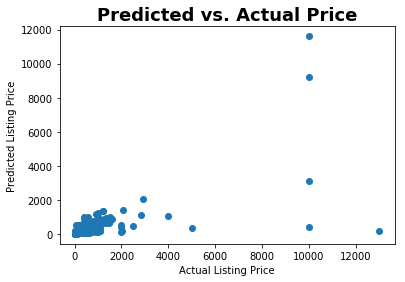

In [253]:
model = LGBMRegressor()
trained_model = train_and_test(listing_data, model, 0.3)

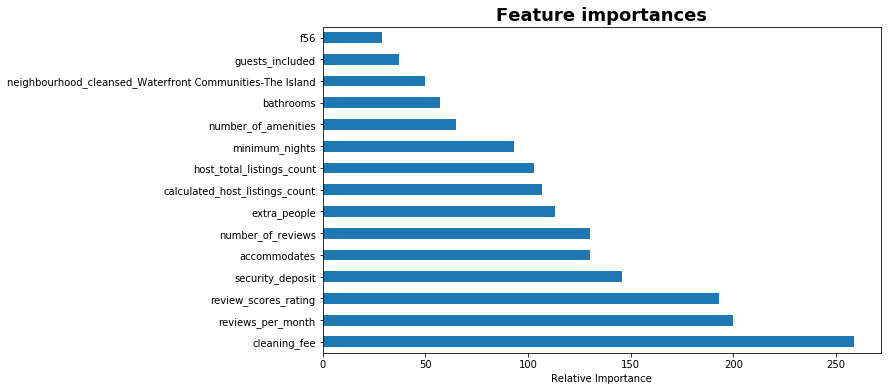

In [248]:
feat_imp = pd.Series(trained_model.feature_importances_,
                     index=listing_data.columns.drop('price'))
feat_imp.nlargest(15).plot(kind='barh', figsize=(10, 6))
plt.xlabel('Relative Importance')
plt.title("Feature importances", fontsize=18, fontweight='bold')
plt.show()